In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

import feather

from tqdm import tqdm_notebook as tqdm

from tqdm import tqdm_pandas

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from multiprocessing import Pool

## Loading and setting up the data

In [2]:
se = feather.read_dataframe("../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather")
se = se.set_index(se.columns[0])

In [3]:
 # And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

In [10]:
means = np.empty((se.shape[0], 12, 13)).astype(float)
counts = np.empty((se.shape[0], 12, 13)).astype(int)

for idx, code in enumerate(['next_segment_code_6',
             'next_segment_code_5', 
             'next_segment_code_4', 
             'next_segment_code_3', 
             'next_segment_code_2', 
             'next_segment_code_1', 
             'segment_code',
             'prev_segment_code_1',
             'prev_segment_code_2',
             'prev_segment_code_3',
             'prev_segment_code_4',
             'prev_segment_code_5',
             'prev_segment_code_6',
            ]):
    
    matrix = np.load(f"mtx_{code}_last_12_15.npy")
    
    means[:,:,idx] = matrix[:,1:13].astype(float)
    counts[:,:,idx] = matrix[:,13:].astype(int)
    
    

In [221]:
def calc_offsets(means, counts, slices, axis, column_name, mask_threshold):
    
    mask = np.sum(counts[slices], axis=axis) > mask_threshold
    
    threshold_pass_fraction = np.count_nonzero(mask)/len(mask)
    
    if  threshold_pass_fraction < 0.05:
        raise ValueError('not enough data passing threshold')
    
    print(f"Approximately {threshold_pass_fraction*100:0.2f}% pass the threshold")
    
    data = means[slices][mask]
    
    weights = counts[slices][mask]
    
    masked_data = np.ma.masked_array(data, np.isnan(data))
    
    if column_name is not None:    
        se[column_name] = 0

        se.loc[mask, column_name] = np.ma.average(masked_data, axis=axis, weights=weights)
        
        return
    
    offsets = np.zeros(counts.shape[0])
    
    offsets[mask] = np.ma.average(masked_data, axis=axis, weights=weights)
    
    return offsets, threshold_pass_fraction, np.mean(np.sum(weights, axis=axis))

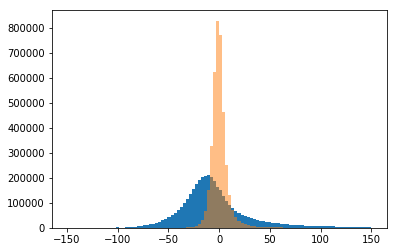

In [30]:
plt.hist(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-150,150));
plt.hist(se['full_mean_minus_recent_15'], bins=100, range=(-150,150), alpha=0.5);

In [123]:
bus_counts = np.sum(counts[:,1:6,5:8], axis=(1,2))

Text(0.5, 1.0, 'Number of data points for last 3 hours incl 6 prev & 6 next segments')

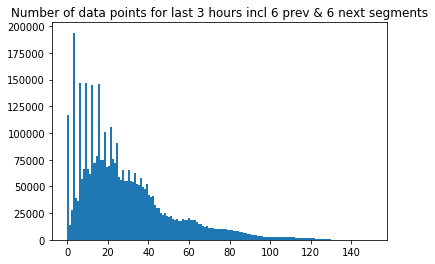

In [127]:
plt.hist(bus_counts, bins=151, range=(0,150));
plt.title("Number of data points for last 3 hours incl 6 prev & 6 next segments")

In [100]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [199]:
def calc_baseline_and_actual(number_of_rows=10000):
    
    se_min = se[:number_of_rows].copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    se_min.reset_index(drop=True, inplace=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")

        run_length = len(run)

        for i in range(min([run_length, 70])):
 
            baseline_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, baseline_index]

            actual_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, actual_index]
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_15mins_mask = actual_array_cum < 15*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_15mins_mask] < actual_array_cum[first_15mins_mask] * 1.1) & \
                    (baseline_array_cum[first_15mins_mask] > actual_array_cum[first_15mins_mask] * 0.9))
    
    return baseline_array_cum, actual_array_cum, baseline_pass_count


In [200]:
baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual()

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


In [217]:
def calc_prediction_cum_journeys(column_name=None, offsets=None, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows = 10000):
    
    se_min = se[:number_of_rows].copy()
    
    if column_name is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min[column_name]/100))
    
    if offsets is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (offsets[:number_of_rows]/100))
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min.reset_index(drop=True, inplace=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")

        run_length = len(run)

        for i in range(min([run_length, 70])):

            predict_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, prediction_index]
            
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_15mins_mask = actual_array_cum < 15*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_15mins_mask] < actual_array_cum[first_15mins_mask] * 1.1) & \
                    (baseline_array_cum[first_15mins_mask] > actual_array_cum[first_15mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_15mins_mask] < actual_array_cum[first_15mins_mask] * 1.1) & \
                    (predict_array_cum[first_15mins_mask] > actual_array_cum[first_15mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_15mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    

In [227]:
def full_test(slices, threshold, baseline_array_cum, actual_array_cum, column_name=None, axis=(1,2), means=means, counts=counts, number_of_rows=10000):
    try:
        offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, slices, axis, column_name, threshold)
    except ValueError:
        print("Not enough values passed threshold")
        return [], 0, 0, 0, 0
    
    predict_array_cum, pass_count, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, number_of_rows=number_of_rows, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum)
    
    return predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights


In [101]:
calc_offsets(means, counts, np.s_[:,1:,:], (1,2), "full_mean_minus_recent_15", 0)

In [102]:
calc_offsets(means, counts, np.s_[:,1:6,:], (1,2), "full_mean_minus_15_to_90", 0)

In [115]:
calc_offsets(means, counts, np.s_[:,1:6,5:8], (1,2), "narrow_mean_minus_15_to_90", 0)

In [208]:
baseline_pass_count

56841

In [223]:
predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights = full_test(np.s_[:,1:3,:], 20, baseline_array_cum, actual_array_cum)
    

Approximately 74.49% pass the threshold
Approximately 1.80% improvment on baseline
Approximately 37.84% are in 10%


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


In [224]:
mean_weights


57.457920945506075

In [95]:
predict_15onwards_cum, baseline_cum, actual_cum = calc_prediction_cum_journeys('full_mean_minus_recent_15')

In [116]:
predict_narrow_15_90_cum, baseline_narrow_15_90_cum, actual_narrow_15_90_cum = calc_prediction_cum_journeys('narrow_mean_minus_15_to_90')


In [130]:
predict_narrow_15_to_90_t40_cum, baseline_narrow_15_to_90_t40_cum, actual_narrow_15_to_90_t40_cum = calc_prediction_cum_journeys('narrow_mean_minus_15_to_90_t40')


................................................................

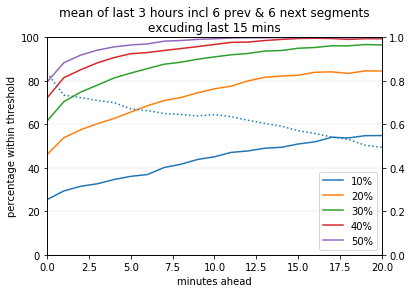

In [96]:
show_accuracy_minutes(predict_cum, actual_cum, "mean of last 3 hours incl 6 prev & 6 next segments\nexcuding last 15 mins")



................................................................

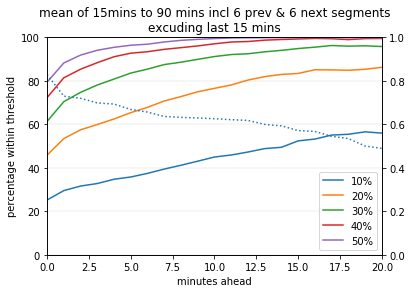

In [104]:
show_accuracy_minutes(predict_15_90_cum, actual_15_90_cum, "mean of 15mins to 90 mins incl 6 prev & 6 next segments\nexcuding last 15 mins")

................................................................

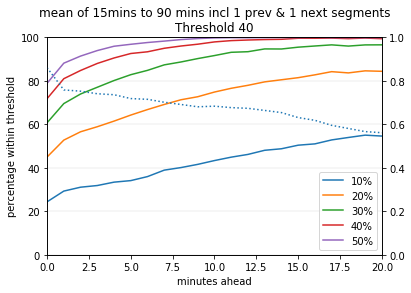

In [131]:

show_accuracy_minutes(predict_narrow_15_to_90_t40_cum, actual_narrow_15_to_90_t40_cum, "mean of 15mins to 90 mins incl 1 prev & 1 next segments\nThreshold 40")


................................................................

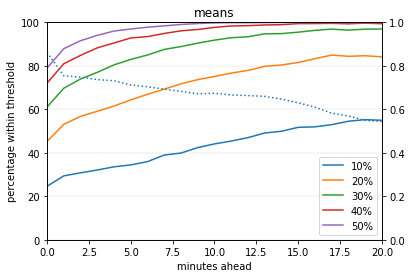

In [97]:
show_accuracy_minutes(baseline_cum, actual_cum, "means")

In [142]:
baseline, _, _= make_accuracy_matrix_minutes(baseline_cum, actual_cum, 10)
with_everything_except_last_15, _, _ = make_accuracy_matrix_minutes(predict_cum, actual_cum, 10)
with_15_90, _, _ = make_accuracy_matrix_minutes(predict_15_90_cum, actual_15_90_cum, 10)
narrow_15_90, _, _ = make_accuracy_matrix_minutes(predict_narrow_15_90_cum, actual_narrow_15_90_cum, 10)
narrow_15_90_t40, _, _ = make_accuracy_matrix_minutes(predict_narrow_15_to_90_t40_cum, actual_narrow_15_to_90_t40_cum, 10)
wide_15_45_t20, _, _ = make_accuracy_matrix_minutes(predict_13_wide_15_45_mins_t20_cum, actual_narrow_15_to_90_t40_cum, 10)



................................................................................................................................................................................................................................................................................................................................................................................................

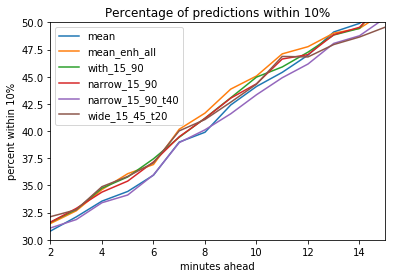

In [143]:
plt.plot(baseline[0,:], label="mean")
# plt.plot(results_enh7[0,:], label="mean_enh7")
plt.plot(with_everything_except_last_15[0,:], label="mean_enh_all")
plt.plot(with_15_90[0,:], label="with_15_90")
plt.plot(narrow_15_90[0,:], label="narrow_15_90")
plt.plot(narrow_15_90_t40[0,:], label="narrow_15_90_t40")
plt.plot(wide_15_45_t20[0,:], label="wide_15_45_t20")

plt.legend()
plt.xlim(2,15)
plt.ylim(30,50)
plt.title("Percentage of predictions within 10%")
plt.xlabel("minutes ahead")
plt.ylabel("percent within 10%")
plt.show()

In [225]:
baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual(500000)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in less


In [229]:
with open("post_noise_width_time_threshold_test.csv", "w") as f: 
    f.write("width,time,threshold,threshold_pass_fraction,mean_weights,pass_count,pass_fraction\n")
    for width in range(7):
        for time in range(0,11,2):
            for threshold in [0,5,10,15,20,25,30,35,40,50,60,80,100]:
                print(f"w: {width}, t:15-{(time+2)*15}, t:{threshold}")
    #             _, _, _, pass_count = full_test(np.s_[:,1:time+2,7-width:7+width+1], threshold, number_of_rows=50000)
                predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights = full_test(np.s_[:,1:time+2,7-width:7+width+1], threshold, baseline_array_cum, actual_array_cum, number_of_rows=500000)
        
                f.write(f"{width},{(time+2)*15},{threshold},{threshold_pass_fraction},{mean_weights},{pass_count},{pass_fraction}\n")
                f.flush()
    
            
            

w: 0, t:15-30, t:0
Approximately 74.23% pass the threshold


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


Approximately -6.66% improvment on baseline
Approximately 35.49% are in 10%
w: 0, t:15-30, t:5
Approximately 5.43% pass the threshold
Approximately 0.00% improvment on baseline
Approximately 38.02% are in 10%
w: 0, t:15-30, t:10
Not enough values passed threshold
w: 0, t:15-30, t:15
Not enough values passed threshold
w: 0, t:15-30, t:20
Not enough values passed threshold
w: 0, t:15-30, t:25
Not enough values passed threshold
w: 0, t:15-30, t:30
Not enough values passed threshold
w: 0, t:15-30, t:35
Not enough values passed threshold
w: 0, t:15-30, t:40
Not enough values passed threshold
w: 0, t:15-30, t:50
Not enough values passed threshold
w: 0, t:15-30, t:60
Not enough values passed threshold
w: 0, t:15-30, t:80
Not enough values passed threshold
w: 0, t:15-30, t:100
Not enough values passed threshold
w: 0, t:15-60, t:0
Approximately 89.52% pass the threshold
Approximately -5.19% improvment on baseline
Approximately 36.04% are in 10%
w: 0, t:15-60, t:5
Approximately 38.62% pass the t

Not enough values passed threshold
w: 1, t:15-30, t:80
Not enough values passed threshold
w: 1, t:15-30, t:100
Not enough values passed threshold
w: 1, t:15-60, t:0
Approximately 94.16% pass the threshold
Approximately -3.55% improvment on baseline
Approximately 36.67% are in 10%
w: 1, t:15-60, t:5
Approximately 79.39% pass the threshold
Approximately -1.01% improvment on baseline
Approximately 37.63% are in 10%
w: 1, t:15-60, t:10
Approximately 58.83% pass the threshold
Approximately -0.12% improvment on baseline
Approximately 37.97% are in 10%
w: 1, t:15-60, t:15
Approximately 42.16% pass the threshold
Approximately 0.14% improvment on baseline
Approximately 38.07% are in 10%
w: 1, t:15-60, t:20
Approximately 30.61% pass the threshold
Approximately 0.16% improvment on baseline
Approximately 38.08% are in 10%
w: 1, t:15-60, t:25
Approximately 21.14% pass the threshold
Approximately 0.16% improvment on baseline
Approximately 38.08% are in 10%
w: 1, t:15-60, t:30
Approximately 15.40% pa

Approximately 25.65% pass the threshold
Approximately 0.25% improvment on baseline
Approximately 38.11% are in 10%
w: 1, t:15-180, t:100
Approximately 17.26% pass the threshold
Approximately 0.33% improvment on baseline
Approximately 38.14% are in 10%
w: 2, t:15-30, t:0
Approximately 87.31% pass the threshold
Approximately -5.73% improvment on baseline
Approximately 35.84% are in 10%
w: 2, t:15-30, t:5
Approximately 59.44% pass the threshold
Approximately -1.40% improvment on baseline
Approximately 37.48% are in 10%
w: 2, t:15-30, t:10
Approximately 34.40% pass the threshold
Approximately -0.22% improvment on baseline
Approximately 37.93% are in 10%
w: 2, t:15-30, t:15
Approximately 18.84% pass the threshold
Approximately 0.09% improvment on baseline
Approximately 38.05% are in 10%
w: 2, t:15-30, t:20
Approximately 9.88% pass the threshold
Approximately 0.20% improvment on baseline
Approximately 38.09% are in 10%
w: 2, t:15-30, t:25
Not enough values passed threshold
w: 2, t:15-30, t:3

Approximately 98.35% pass the threshold
Approximately -0.00% improvment on baseline
Approximately 38.02% are in 10%
w: 2, t:15-180, t:5
Approximately 95.80% pass the threshold
Approximately 0.35% improvment on baseline
Approximately 38.15% are in 10%
w: 2, t:15-180, t:10
Approximately 92.12% pass the threshold
Approximately 0.64% improvment on baseline
Approximately 38.26% are in 10%
w: 2, t:15-180, t:15
Approximately 89.04% pass the threshold
Approximately 0.78% improvment on baseline
Approximately 38.31% are in 10%
w: 2, t:15-180, t:20
Approximately 86.20% pass the threshold
Approximately 0.84% improvment on baseline
Approximately 38.34% are in 10%
w: 2, t:15-180, t:25
Approximately 82.63% pass the threshold
Approximately 0.93% improvment on baseline
Approximately 38.37% are in 10%
w: 2, t:15-180, t:30
Approximately 78.84% pass the threshold
Approximately 0.95% improvment on baseline
Approximately 38.38% are in 10%
w: 2, t:15-180, t:35
Approximately 75.69% pass the threshold
Approxim

Approximately 98.50% pass the threshold
Approximately -0.25% improvment on baseline
Approximately 37.92% are in 10%
w: 3, t:15-150, t:5
Approximately 97.43% pass the threshold
Approximately -0.08% improvment on baseline
Approximately 37.99% are in 10%
w: 3, t:15-150, t:10
Approximately 94.71% pass the threshold
Approximately 0.26% improvment on baseline
Approximately 38.12% are in 10%
w: 3, t:15-150, t:15
Approximately 91.15% pass the threshold
Approximately 0.56% improvment on baseline
Approximately 38.23% are in 10%
w: 3, t:15-150, t:20
Approximately 89.01% pass the threshold
Approximately 0.62% improvment on baseline
Approximately 38.25% are in 10%
w: 3, t:15-150, t:25
Approximately 86.43% pass the threshold
Approximately 0.69% improvment on baseline
Approximately 38.28% are in 10%
w: 3, t:15-150, t:30
Approximately 83.19% pass the threshold
Approximately 0.81% improvment on baseline
Approximately 38.33% are in 10%
w: 3, t:15-150, t:35
Approximately 79.99% pass the threshold
Approxi

Approximately 41.33% pass the threshold
Approximately 0.58% improvment on baseline
Approximately 38.24% are in 10%
w: 4, t:15-90, t:100
Approximately 29.41% pass the threshold
Approximately 0.33% improvment on baseline
Approximately 38.14% are in 10%
w: 4, t:15-120, t:0
Approximately 98.40% pass the threshold
Approximately -0.68% improvment on baseline
Approximately 37.76% are in 10%
w: 4, t:15-120, t:5
Approximately 97.27% pass the threshold
Approximately -0.40% improvment on baseline
Approximately 37.87% are in 10%
w: 4, t:15-120, t:10
Approximately 94.38% pass the threshold
Approximately 0.25% improvment on baseline
Approximately 38.11% are in 10%
w: 4, t:15-120, t:15
Approximately 92.08% pass the threshold
Approximately 0.45% improvment on baseline
Approximately 38.19% are in 10%
w: 4, t:15-120, t:20
Approximately 89.62% pass the threshold
Approximately 0.61% improvment on baseline
Approximately 38.25% are in 10%
w: 4, t:15-120, t:25
Approximately 87.25% pass the threshold
Approxim

Approximately 48.76% pass the threshold
Approximately 0.55% improvment on baseline
Approximately 38.23% are in 10%
w: 5, t:15-60, t:60
Approximately 39.55% pass the threshold
Approximately 0.37% improvment on baseline
Approximately 38.16% are in 10%
w: 5, t:15-60, t:80
Approximately 25.14% pass the threshold
Approximately 0.15% improvment on baseline
Approximately 38.08% are in 10%
w: 5, t:15-60, t:100
Approximately 16.33% pass the threshold
Approximately 0.23% improvment on baseline
Approximately 38.11% are in 10%
w: 5, t:15-90, t:0
Approximately 98.16% pass the threshold
Approximately -1.53% improvment on baseline
Approximately 37.44% are in 10%
w: 5, t:15-90, t:5
Approximately 97.16% pass the threshold
Approximately -1.30% improvment on baseline
Approximately 37.52% are in 10%
w: 5, t:15-90, t:10
Approximately 95.28% pass the threshold
Approximately -1.00% improvment on baseline
Approximately 37.64% are in 10%
w: 5, t:15-90, t:15
Approximately 91.53% pass the threshold
Approximately

Approximately 32.51% pass the threshold
Approximately 0.07% improvment on baseline
Approximately 38.04% are in 10%
w: 6, t:15-30, t:30
Approximately 24.27% pass the threshold
Approximately 0.22% improvment on baseline
Approximately 38.10% are in 10%
w: 6, t:15-30, t:35
Approximately 18.01% pass the threshold
Approximately 0.24% improvment on baseline
Approximately 38.11% are in 10%
w: 6, t:15-30, t:40
Approximately 12.98% pass the threshold
Approximately 0.24% improvment on baseline
Approximately 38.11% are in 10%
w: 6, t:15-30, t:50
Approximately 6.03% pass the threshold
Approximately 0.21% improvment on baseline
Approximately 38.10% are in 10%
w: 6, t:15-30, t:60
Not enough values passed threshold
w: 6, t:15-30, t:80
Not enough values passed threshold
w: 6, t:15-30, t:100
Not enough values passed threshold
w: 6, t:15-60, t:0
Approximately 97.46% pass the threshold
Approximately -2.94% improvment on baseline
Approximately 36.90% are in 10%
w: 6, t:15-60, t:5
Approximately 95.05% pass 

Approximately 0.55% improvment on baseline
Approximately 38.23% are in 10%
w: 6, t:15-180, t:15
Approximately 95.96% pass the threshold
Approximately 0.71% improvment on baseline
Approximately 38.29% are in 10%
w: 6, t:15-180, t:20
Approximately 94.90% pass the threshold
Approximately 0.80% improvment on baseline
Approximately 38.32% are in 10%
w: 6, t:15-180, t:25
Approximately 93.22% pass the threshold
Approximately 0.91% improvment on baseline
Approximately 38.36% are in 10%
w: 6, t:15-180, t:30
Approximately 91.95% pass the threshold
Approximately 0.91% improvment on baseline
Approximately 38.37% are in 10%
w: 6, t:15-180, t:35
Approximately 90.77% pass the threshold
Approximately 0.96% improvment on baseline
Approximately 38.38% are in 10%
w: 6, t:15-180, t:40
Approximately 89.47% pass the threshold
Approximately 1.05% improvment on baseline
Approximately 38.42% are in 10%
w: 6, t:15-180, t:50
Approximately 86.92% pass the threshold
Approximately 1.13% improvment on baseline
Appro

In [188]:
np.unravel_index(results.argmax(), results.shape)

(2, 4, 1)

In [190]:
results.max()

297763.0

In [193]:
full_test(np.s_[:,1:10,5:10], 30, number_of_rows=100000)

Approximately 75.51% pass the threshold
Approximately 0.30% improvment on baseline
Approximately 38.79% are in 10%


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


(array([[ 17.86      ,          nan,          nan, ...,          nan,
                  nan,          nan],
        [ 17.16326531,  35.02326531,          nan, ...,          nan,
                  nan,          nan],
        [ 18.64583333,  35.80909864,  53.66909864, ...,          nan,
                  nan,          nan],
        ...,
        [ 70.        ,  90.73333333, 109.98333333, ...,          nan,
                  nan,          nan],
        [ 95.625     , 165.625     , 186.35833333, ...,          nan,
                  nan,          nan],
        [ 64.80769231, 160.43269231, 230.43269231, ...,          nan,
                  nan,          nan]]),
 array([[ 17.86      ,          nan,          nan, ...,          nan,
                  nan,          nan],
        [ 17.16326531,  35.02326531,          nan, ...,          nan,
                  nan,          nan],
        [ 18.64583333,  35.80909864,  53.66909864, ...,          nan,
                  nan,          nan],
        ...,
